In [ ]:
import matplotlib
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Button
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import matplotlib.cm as cm
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist, euclidean
import pickle

In [ ]:
# ==========================================
# LOAD PREPROCESSED DATA
# ==========================================
print("=" * 70)
print("LOADING PREPROCESSED DATA")
print("=" * 70)

data_dir = 'Data/preprocessed'

# Load preprocessing info
with open(f'{data_dir}/preprocess_info.pkl', 'rb') as f:
    preprocess_info = pickle.load(f)

# Load preprocessed arrays
train_input_xyz = np.load(f'{data_dir}/train_input_xyz.npy')
test_input_xyz = np.load(f'{data_dir}/test_input_xyz.npy')
train_scalars = np.load(f'{data_dir}/train_scalars.npy')
test_scalars = np.load(f'{data_dir}/test_scalars.npy')

# Load normalization statistics
stats = np.load(f'{data_dir}/normalization_stats.npz')
scalar_min = preprocess_info['scalar_min']
scalar_max = preprocess_info['scalar_max']

# Extract metadata
scalar_columns = preprocess_info['scalar_columns']

print(f"\n✅ Data loaded successfully!")
print(f"   Train samples: {len(train_input_xyz)}")
print(f"   Test samples: {len(test_input_xyz)}")
print(f"   Input shape: {train_input_xyz.shape}")
print(f"   Scalar shape: {train_scalars.shape}")

# Combine for analysis
all_input_xyz = np.vstack([train_input_xyz, test_input_xyz])
all_scalars_original = np.vstack([train_scalars, test_scalars])

print(f"\n✅ Total samples: {len(all_input_xyz)}")
print(f"   Scalar range: {all_scalars_original.shape}")

print("=" * 70)

In [ ]:
class PointNetBaseline(nn.Module):
    def __init__(self):
        super(PointNetBaseline, self).__init__()
        
        # Local Feature Extraction
        self.conv1 = nn.Conv1d(3, 33, 1)
        self.bn1 = nn.BatchNorm1d(33)
        self.conv2 = nn.Conv1d(33, 33, 1)
        self.bn2 = nn.BatchNorm1d(33)
        self.conv3 = nn.Conv1d(33, 33, 1)
        self.bn3 = nn.BatchNorm1d(33)
        
        # Global Feature Extraction
        self.conv4 = nn.Conv1d(33, 67, 1)
        self.bn4 = nn.BatchNorm1d(67)
        self.conv5 = nn.Conv1d(67, 542, 1)
        self.bn5 = nn.BatchNorm1d(542)
        
        # Field Prediction Head
        self.conv6 = nn.Conv1d(575, 271, 1)
        self.bn6 = nn.BatchNorm1d(271)
        self.conv7 = nn.Conv1d(271, 135, 1)
        self.bn7 = nn.BatchNorm1d(135)
        self.conv8 = nn.Conv1d(135, 67, 1)
        self.bn8 = nn.BatchNorm1d(67)
        self.conv9 = nn.Conv1d(67, 4, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x)))
        
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        global_feature = torch.max(x, 2, keepdim=True)[0]
        global_feature_repeated = global_feature.repeat(1, 1, local_features.size(2))
        
        combined = torch.cat([global_feature_repeated, local_features], dim=1)
        x = F.relu(self.bn6(self.conv6(combined)))
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = torch.sigmoid(self.conv9(x))
        
        return x
    
class PointNetLatent(nn.Module):
    """Extract latent features before the field prediction head"""
    def __init__(self, pointnet_model):
        super().__init__()
        self.conv1 = pointnet_model.conv1
        self.bn1 = pointnet_model.bn1
        self.conv2 = pointnet_model.conv2
        self.bn2 = pointnet_model.bn2
        self.conv3 = pointnet_model.conv3
        self.bn3 = pointnet_model.bn3
        self.conv4 = pointnet_model.conv4
        self.bn4 = pointnet_model.bn4
        self.conv5 = pointnet_model.conv5
        self.bn5 = pointnet_model.bn5

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        local_features = F.relu(self.bn3(self.conv3(x)))
        
        x = F.relu(self.bn4(self.conv4(local_features)))
        x = F.relu(self.bn5(self.conv5(x)))
        
        global_feature = torch.max(x, 2, keepdim=True)[0]
        global_feature = global_feature.squeeze(-1)
        
        return global_feature

class ScalarHead(nn.Module):
    """MLP head to predict 3 scalars from latent features"""
    def __init__(self, latent_dim=542, hidden_dim=256):
        super().__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        
        self.fc3 = nn.Linear(hidden_dim // 2, 3)

    def forward(self, latent):
        x = F.relu(self.bn1(self.fc1(latent)))
        x = F.dropout(x, p=0.2, training=self.training)
        
        x = F.relu(self.bn2(self.fc2(x)))
        x = F.dropout(x, p=0.2, training=self.training)
        
        output = torch.sigmoid(self.fc3(x))
        return output

In [ ]:
# ==========================================
# SETUP DEVICE AND LOAD MODELS
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

print("\n" + "=" * 70)
print("LOADING PRETRAINED MODELS")
print("=" * 70)

model = PointNetBaseline().to(device)
pointnet_path = 'Data/weight_data/pointnet_best_model.pth'
model.load_state_dict(torch.load(pointnet_path, map_location=device))
model.eval()
print(f"✅ PointNet loaded: {sum(p.numel() for p in model.parameters()):,} parameters")

latent_extractor = PointNetLatent(model).to(device)
latent_extractor.eval()
print(f"✅ Latent extractor ready")

scalar_head = ScalarHead().to(device)
scalar_head_path = 'Data/weight_data/scalar_head_best.pth'
scalar_head.load_state_dict(torch.load(scalar_head_path, map_location=device))
scalar_head.eval()
print(f"✅ Scalar head loaded: {sum(p.numel() for p in scalar_head.parameters()):,} parameters")

print("=" * 70)

Device: cuda

LOADING POINTNET BASELINE MODEL
Total parameters: 246,072
✅ Loaded pretrained PointNet from: Data/weight_data/pointnet_best_model.pth

SETTING UP LATENT FEATURE EXTRACTOR
✅ Latent extractor created from pretrained PointNet

LOADING SCALAR HEAD MODEL
Scalar head parameters: 173,059
✅ Loaded scalar head from: Data/weight_data/scalar_head_best.pth

MODELS READY FOR INFERENCE



EXTRACT LATENT REPRESENTATIONS

Extracting latent features for training data...
✅ Train latent shape: (1684, 542)
Extracting latent features for testing data...
✅ Test latent shape: (421, 542)

NORMALIZE LATENT FEATURES

Normalization statistics (from training data):
  Min per feature: [0.000000, ..., 0.403818]
  Max per feature: [0.000000, ..., 0.641235]

✅ Train latent normalized: (1684, 542)
✅ Test latent normalized: (421, 542)

COMPUTE T-SNE EMBEDDING

Computing t-SNE on 2105 samples...
(This may take a minute...)
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2105 samples in 0.001s...


c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 2105 samples in 2.652s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2105
[t-SNE] Computed conditional probabilities for sample 2000 / 2105
[t-SNE] Computed conditional probabilities for sample 2105 / 2105
[t-SNE] Mean sigma: 0.276009
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.045082
[t-SNE] KL divergence after 1000 iterations: 1.388851

✅ t-SNE embedding computed!
  Train 2D shape: (1684, 2)
  Test 2D shape: (421, 2)

VISUALIZE LATENT SPACE


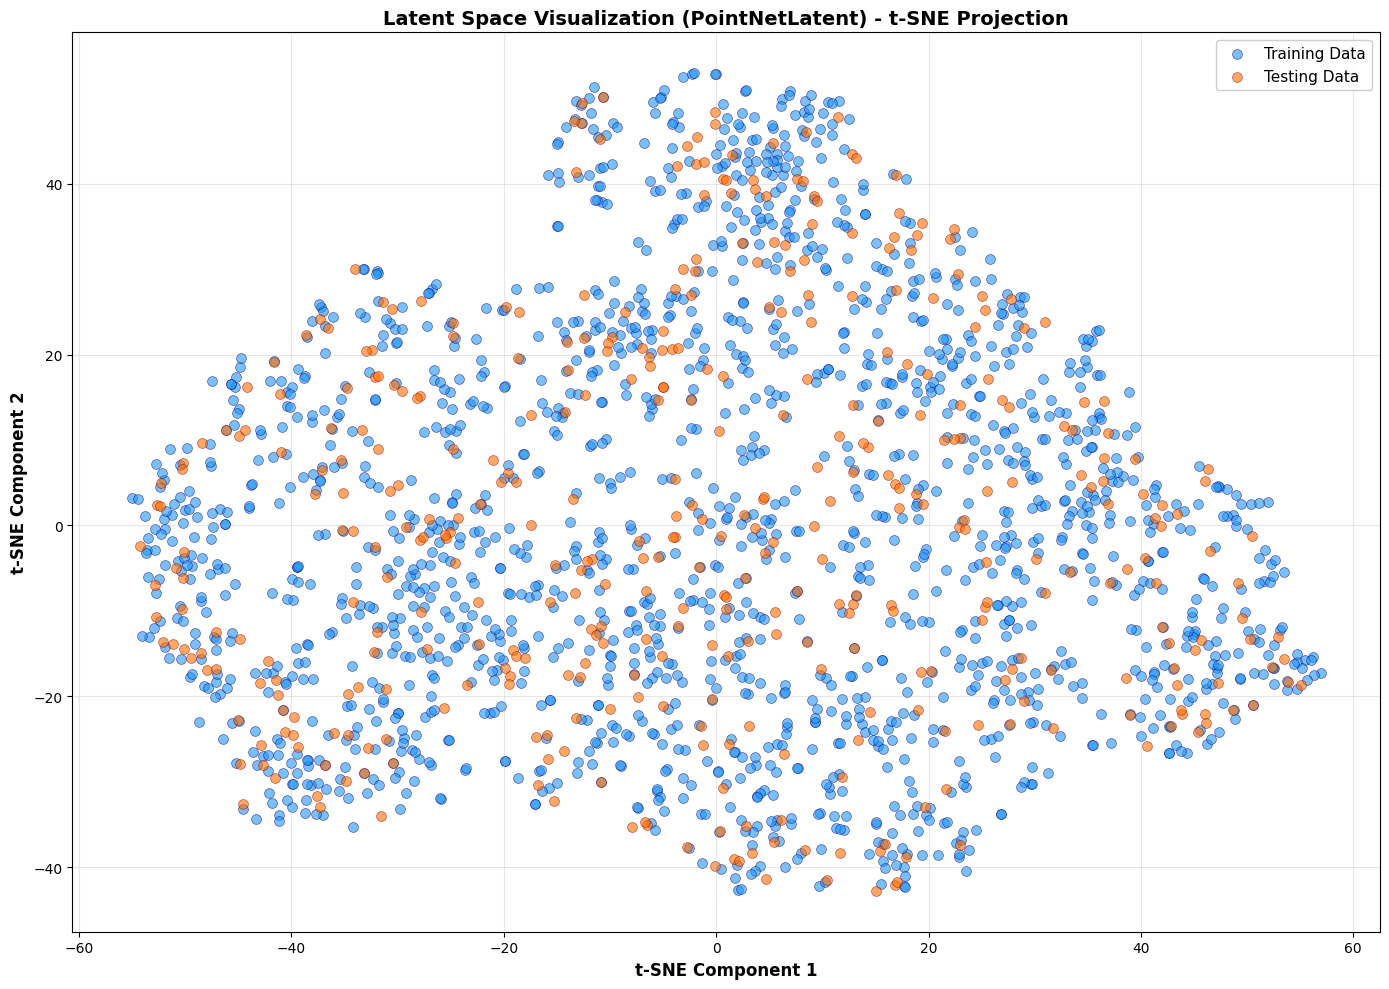


✅ t-SNE visualization complete!

📊 Summary:
  • Training samples: 1684
  • Testing samples: 421
  • Latent dimension (original): 542
  • Latent dimension (t-SNE): 2


In [ ]:
# ==========================================
# EXTRACT LATENT REPRESENTATIONS
# ==========================================
print("\n" + "=" * 70)
print("EXTRACT LATENT REPRESENTATIONS")
print("=" * 70)

# Extract latent features for all training samples
print("\nExtracting latent features for training data...")
train_latent_list = []
with torch.no_grad():
    for i in range(0, len(train_input_xyz), 32):
        batch = torch.from_numpy(train_input_xyz[i:i+32]).float().to(device)
        batch = batch.transpose(1, 2)  # (B, 3, 5000)
        latent = latent_extractor(batch).cpu().numpy()
        train_latent_list.append(latent)

train_latent = np.vstack(train_latent_list)
print(f"✅ Train latent shape: {train_latent.shape}")

# Extract latent features for all testing samples
print("Extracting latent features for testing data...")
test_latent_list = []
with torch.no_grad():
    for i in range(0, len(test_input_xyz), 32):
        batch = torch.from_numpy(test_input_xyz[i:i+32]).float().to(device)
        batch = batch.transpose(1, 2)  # (B, 3, 5000)
        latent = latent_extractor(batch).cpu().numpy()
        test_latent_list.append(latent)

test_latent = np.vstack(test_latent_list)
print(f"✅ Test latent shape: {test_latent.shape}")

# ==========================================
# NORMALIZE LATENT FEATURES
# ==========================================
print("\n" + "=" * 70)
print("NORMALIZE LATENT FEATURES")
print("=" * 70)

# Compute normalization statistics from TRAINING data only
latent_min = train_latent.min(axis=0)
latent_max = train_latent.max(axis=0)

print(f"\nNormalization statistics (from training data):")
print(f"  Min per feature: [{latent_min.min():.6f}, ..., {latent_min.max():.6f}]")
print(f"  Max per feature: [{latent_max.min():.6f}, ..., {latent_max.max():.6f}]")

# Normalize both train and test using train statistics
train_latent_norm = (train_latent - latent_min) / (latent_max - latent_min + 1e-8)
test_latent_norm = (test_latent - latent_min) / (latent_max - latent_min + 1e-8)

# Clip to [0, 1] range
train_latent_norm = np.clip(train_latent_norm, 0, 1)
test_latent_norm = np.clip(test_latent_norm, 0, 1)

print(f"\n✅ Train latent normalized: {train_latent_norm.shape}")
print(f"✅ Test latent normalized: {test_latent_norm.shape}")

# ==========================================
# COMPUTE T-SNE EMBEDDING
# ==========================================
print("\n" + "=" * 70)
print("COMPUTE T-SNE EMBEDDING")
print("=" * 70)

all_latent_norm = np.vstack([train_latent_norm, test_latent_norm])

print(f"\nComputing t-SNE on {len(all_latent_norm)} samples...")
print("(This may take a minute...)")

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
latent_2d = tsne.fit_transform(all_latent_norm)

train_latent_2d = latent_2d[:len(train_latent_norm)]
test_latent_2d = latent_2d[len(train_latent_norm):]

print(f"\n✅ t-SNE embedding computed!")
print(f"  Train 2D shape: {train_latent_2d.shape}")
print(f"  Test 2D shape: {test_latent_2d.shape}")

# ==========================================
# VISUALIZE T-SNE PLOT
# ==========================================
print("\n" + "=" * 70)
print("VISUALIZE LATENT SPACE")
print("=" * 70)

fig, ax = plt.subplots(figsize=(14, 10))

scatter_train = ax.scatter(
    train_latent_2d[:, 0], train_latent_2d[:, 1],
    c='#2196F3', s=50, alpha=0.6, label='Training Data', edgecolors='navy', linewidth=0.5
)

scatter_test = ax.scatter(
    test_latent_2d[:, 0], test_latent_2d[:, 1],
    c='#FF6F00', s=50, alpha=0.6, label='Testing Data', edgecolors='darkred', linewidth=0.5
)

ax.set_xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
ax.set_title('Latent Space Visualization (PointNetLatent) - t-SNE Projection', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ t-SNE visualization complete!")
print(f"\n📊 Summary:")
print(f"  • Training samples: {len(train_latent_2d)}")
print(f"  • Testing samples: {len(test_latent_2d)}")
print(f"  • Latent dimension (original): 542")
print(f"  • Latent dimension (t-SNE): 2")


K-MEANS CLUSTERING

Fitting K-means with k=20 clusters...
Initialization complete
Iteration 0, inertia 1483.2958984375.
Iteration 1, inertia 1055.9111328125.
Iteration 2, inertia 1025.2769775390625.
Iteration 3, inertia 1012.1685180664062.
Iteration 4, inertia 1006.5657958984375.
Iteration 5, inertia 1001.6279296875.
Iteration 6, inertia 998.6868896484375.
Iteration 7, inertia 996.5608520507812.
Iteration 8, inertia 995.0425415039062.
Iteration 9, inertia 993.7296142578125.
Iteration 10, inertia 992.1791381835938.
Iteration 11, inertia 990.3508911132812.
Iteration 12, inertia 988.7984619140625.
Iteration 13, inertia 987.3529052734375.
Iteration 14, inertia 986.5469970703125.
Iteration 15, inertia 985.90771484375.
Iteration 16, inertia 985.6033325195312.
Iteration 17, inertia 985.3773193359375.
Iteration 18, inertia 985.0910034179688.
Iteration 19, inertia 984.5110473632812.
Iteration 20, inertia 984.2255249023438.
Iteration 21, inertia 984.0000610351562.
Iteration 22, inertia 983.8937

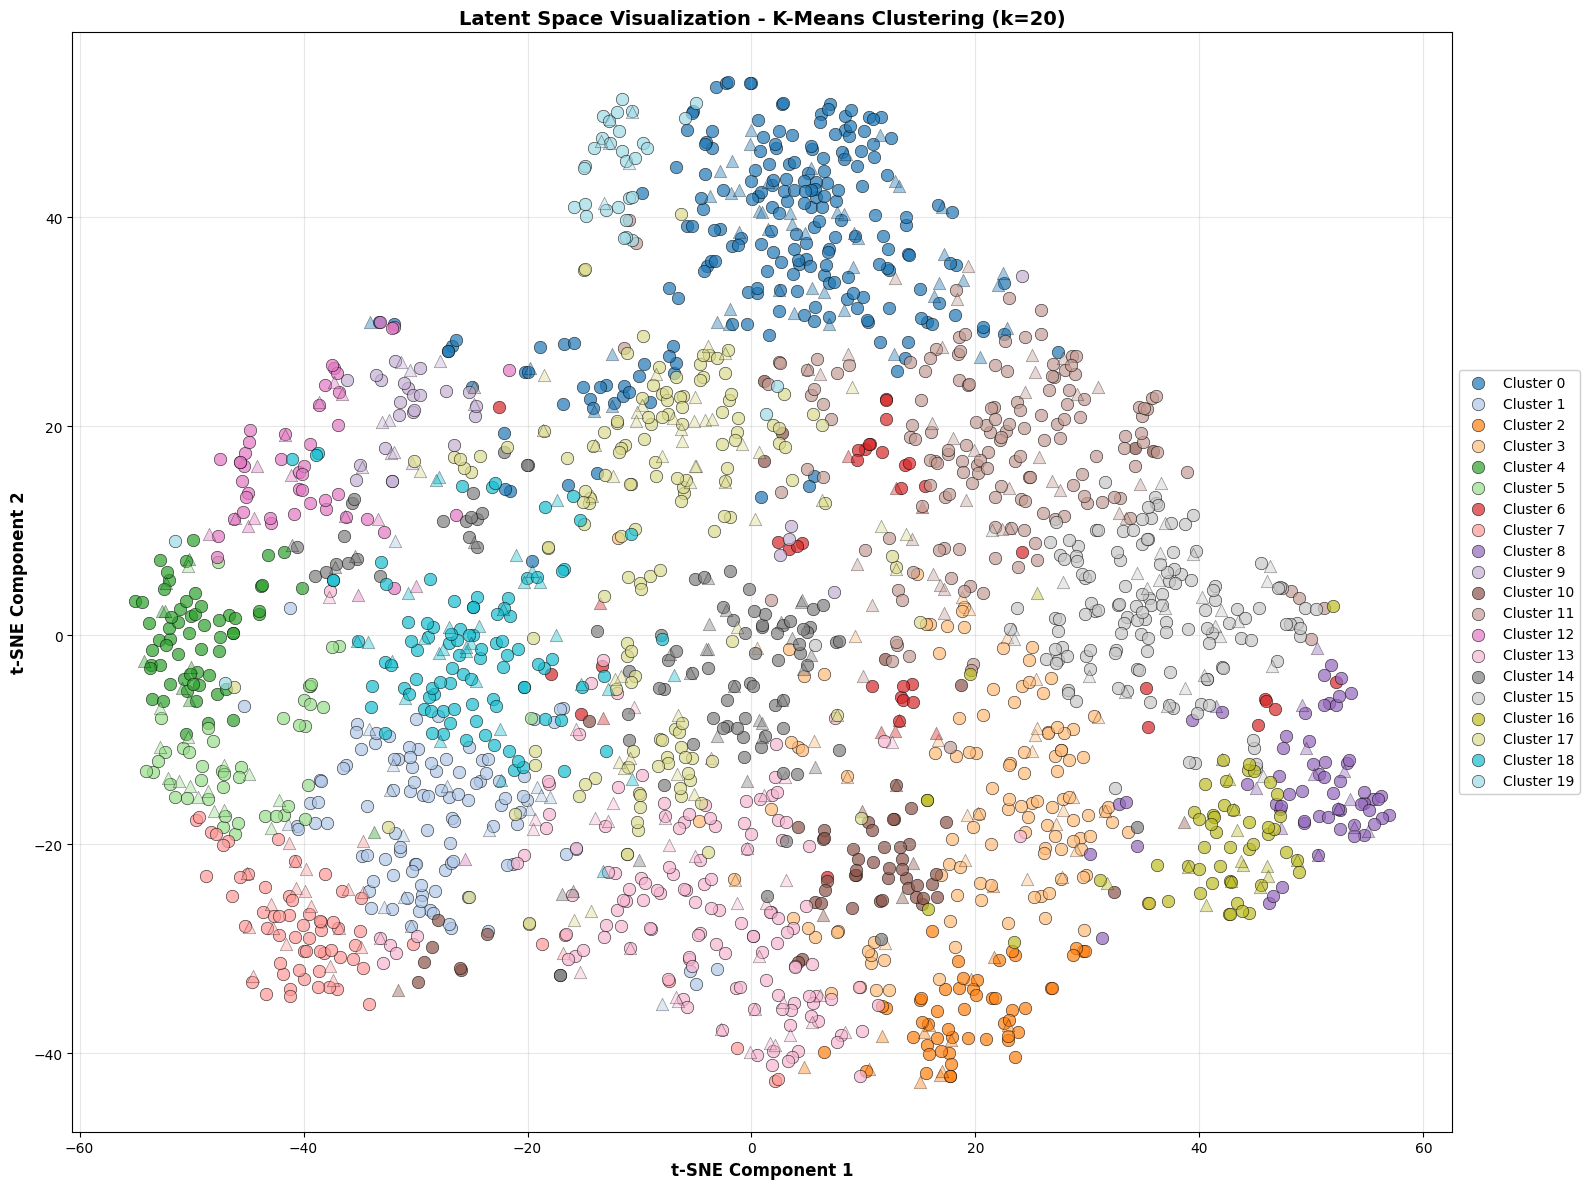


✅ Clustered t-SNE visualization complete!

📊 Summary:
  • Training samples: 1684
  • Testing samples: 421
  • Number of clusters: 20
  • Circles (o): Training data
  • Triangles (^): Testing data
  • Color: Cluster assignment


In [ ]:
# ==========================================
# K-MEANS CLUSTERING ON LATENT SPACE
# ==========================================
print("\n" + "=" * 70)
print("K-MEANS CLUSTERING")
print("=" * 70)

n_clusters = 20
print(f"\nFitting K-means with k={n_clusters} clusters...")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, verbose=1)
cluster_labels = kmeans.fit_predict(all_latent_norm)

train_clusters = cluster_labels[:len(train_latent_norm)]
test_clusters = cluster_labels[len(train_latent_norm):]

print(f"✅ K-means clustering complete!")
print(f"\nCluster distribution (training data):")
unique_train, counts_train = np.unique(train_clusters, return_counts=True)
for cluster_id, count in zip(unique_train, counts_train):
    print(f"  Cluster {cluster_id:2d}: {count:4d} samples")

print(f"\nCluster distribution (testing data):")
unique_test, counts_test = np.unique(test_clusters, return_counts=True)
for cluster_id, count in zip(unique_test, counts_test):
    print(f"  Cluster {cluster_id:2d}: {count:4d} samples")

# ==========================================
# VISUALIZE T-SNE PLOT WITH K-MEANS CLUSTERS
# ==========================================
print("\n" + "=" * 70)
print("VISUALIZE LATENT SPACE WITH CLUSTERS")
print("=" * 70)

fig, ax = plt.subplots(figsize=(16, 12))

cmap = plt.colormaps['tab20']
colors = cmap(np.linspace(0, 1, n_clusters))

for cluster_id in range(n_clusters):
    train_mask = train_clusters == cluster_id
    if train_mask.any():
        ax.scatter(
            train_latent_2d[train_mask, 0], train_latent_2d[train_mask, 1],
            c=[colors[cluster_id]], s=80, alpha=0.7, 
            label=f'Cluster {cluster_id} (train)', 
            edgecolors='black', linewidth=0.5, marker='o'
        )
    
    test_mask = test_clusters == cluster_id
    if test_mask.any():
        ax.scatter(
            test_latent_2d[test_mask, 0], test_latent_2d[test_mask, 1],
            c=[colors[cluster_id]], s=80, alpha=0.4, 
            label=f'Cluster {cluster_id} (test)', 
            edgecolors='black', linewidth=0.5, marker='^'
        )

ax.set_xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
ax.set_title(f'Latent Space Visualization - K-Means Clustering (k={n_clusters})', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

handles, labels = ax.get_legend_handles_labels()
legend_handles = [handles[2*i] for i in range(n_clusters) if 2*i < len(handles)]
legend_labels = [f'Cluster {i}' for i in range(n_clusters)]
ax.legend(legend_handles, legend_labels, loc='center left', bbox_to_anchor=(1, 0.5), 
          fontsize=10, ncol=1, framealpha=0.95)

plt.tight_layout()
plt.show()

print("\n✅ Clustered t-SNE visualization complete!")


FIND NEAREST & FARTHEST NEIGHBORS IN LATENT SPACE

QUERY SAMPLE
Index: 1547
Split: TRAIN
Cluster: 18
Sample name: dia_616_138

NEAREST NEIGHBOR (in latent space)
Index: 1131
Split: TRAIN
Cluster: 18
Distance: 0.185109
Sample name: dia_15_519

FARTHEST NEIGHBOR (in latent space)
Index: 1233
Split: TRAIN
Cluster: 16
Distance: 2.422146
Sample name: dia_214_296


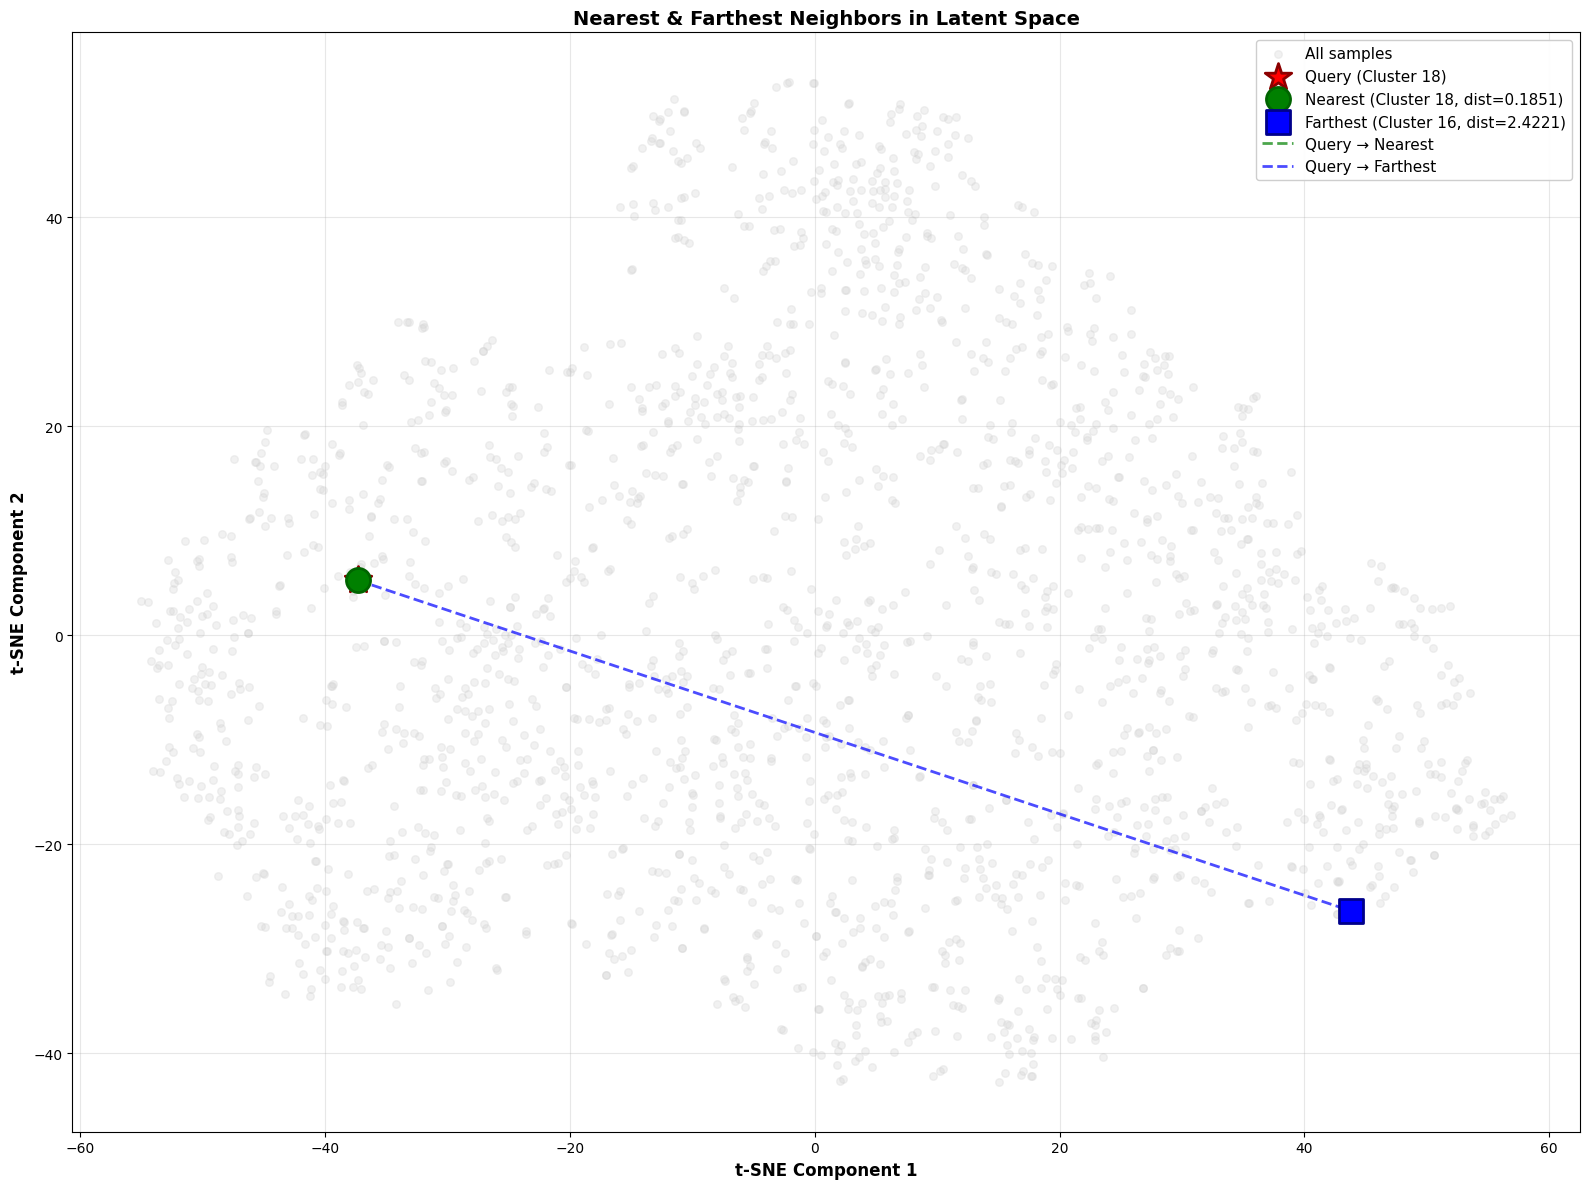


✅ Neighbor analysis complete!

📊 Summary:
  • Query → Nearest distance: 0.185109
  • Query → Farthest distance: 2.422146
  • Distance ratio: 13.08x

VISUALIZE 3D POINT CLOUDS


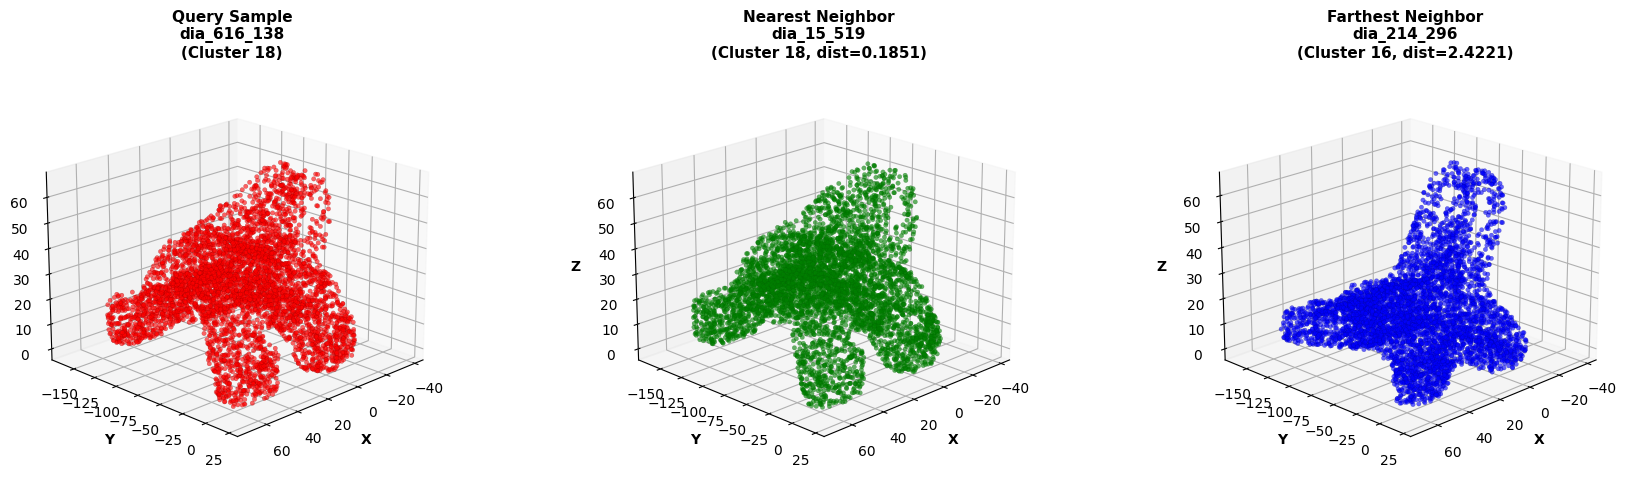


✅ Point clouds visualized!

📊 Geometry Summary:
  • Query: 5000 points
  • Nearest: 5000 points
  • Farthest: 5000 points


In [ ]:
# ==========================================
# FIND NEAREST & FARTHEST NEIGHBORS IN LATENT SPACE
# ==========================================
print("\n" + "=" * 70)
print("FIND NEAREST & FARTHEST NEIGHBORS IN LATENT SPACE")
print("=" * 70)

def find_neighbors_in_latent_space(query_idx, all_latent_norm, train_size):
    """Find nearest and farthest neighbors to a query sample in latent space"""
    
    query_latent = all_latent_norm[query_idx:query_idx+1]
    distances = cdist(query_latent, all_latent_norm, metric='euclidean')[0]
    distances[query_idx] = np.inf
    
    valid_mask = np.isfinite(distances)
    valid_indices = np.where(valid_mask)[0]
    nearest_idx = valid_indices[np.argmin(distances[valid_mask])]
    farthest_idx = valid_indices[np.argmax(distances[valid_mask])]
    
    is_query_train = query_idx < train_size
    is_nearest_train = nearest_idx < train_size
    is_farthest_train = farthest_idx < train_size
    
    return {
        'query_idx': query_idx,
        'query_is_train': is_query_train,
        'query_cluster': cluster_labels[query_idx],
        'nearest_idx': nearest_idx,
        'nearest_is_train': is_nearest_train,
        'nearest_cluster': cluster_labels[nearest_idx],
        'nearest_dist': distances[nearest_idx],
        'farthest_idx': farthest_idx,
        'farthest_is_train': is_farthest_train,
        'farthest_cluster': cluster_labels[farthest_idx],
        'farthest_dist': distances[farthest_idx],
    }

# Random sampling & visualization
np.random.seed(None)
random_sample_idx = np.random.randint(0, len(all_latent_norm))

result = find_neighbors_in_latent_space(random_sample_idx, all_latent_norm, len(train_latent_norm))

print(f"\n{'='*70}")
print(f"QUERY SAMPLE")
print(f"{'='*70}")
print(f"Index: {result['query_idx']}")
print(f"Split: {'TRAIN' if result['query_is_train'] else 'TEST'}")
print(f"Cluster: {result['query_cluster']}")

print(f"\n{'='*70}")
print(f"NEAREST NEIGHBOR (in latent space)")
print(f"{'='*70}")
print(f"Index: {result['nearest_idx']}")
print(f"Split: {'TRAIN' if result['nearest_is_train'] else 'TEST'}")
print(f"Cluster: {result['nearest_cluster']}")
print(f"Distance: {result['nearest_dist']:.6f}")

print(f"\n{'='*70}")
print(f"FARTHEST NEIGHBOR (in latent space)")
print(f"{'='*70}")
print(f"Index: {result['farthest_idx']}")
print(f"Split: {'TRAIN' if result['farthest_is_train'] else 'TEST'}")
print(f"Cluster: {result['farthest_cluster']}")
print(f"Distance: {result['farthest_dist']:.6f}")

# VISUALIZE IN T-SNE SPACE
fig, ax = plt.subplots(figsize=(16, 12))

ax.scatter(latent_2d[:, 0], latent_2d[:, 1], 
           c='lightgray', s=30, alpha=0.3, label='All samples')

ax.scatter(latent_2d[result['query_idx'], 0], latent_2d[result['query_idx'], 1],
           c='red', s=400, marker='*', edgecolors='darkred', linewidth=2,
           label=f"Query (Cluster {result['query_cluster']})", zorder=5)

ax.scatter(latent_2d[result['nearest_idx'], 0], latent_2d[result['nearest_idx'], 1],
           c='green', s=300, marker='o', edgecolors='darkgreen', linewidth=2,
           label=f"Nearest (dist={result['nearest_dist']:.4f})", zorder=5)

ax.scatter(latent_2d[result['farthest_idx'], 0], latent_2d[result['farthest_idx'], 1],
           c='blue', s=300, marker='s', edgecolors='darkblue', linewidth=2,
           label=f"Farthest (dist={result['farthest_dist']:.4f})", zorder=5)

ax.plot([latent_2d[result['query_idx'], 0], latent_2d[result['nearest_idx'], 0]],
        [latent_2d[result['query_idx'], 1], latent_2d[result['nearest_idx'], 1]],
        'g--', linewidth=2, alpha=0.7, label='Query → Nearest')

ax.plot([latent_2d[result['query_idx'], 0], latent_2d[result['farthest_idx'], 0]],
        [latent_2d[result['query_idx'], 1], latent_2d[result['farthest_idx'], 1]],
        'b--', linewidth=2, alpha=0.7, label='Query → Farthest')

ax.set_xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
ax.set_title('Nearest & Farthest Neighbors in Latent Space', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=11, framealpha=0.95)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n✅ Neighbor analysis complete!")


DISTANCE ANALYSIS: POINT CLOUD vs LATENT SPACE

Extracting point cloud data for all samples...
✅ Point cloud data shape: (2105, 15000)

Computing Euclidean distances in point cloud space (15000 dims)...

📊 Point Cloud Space (15,000 dimensions):
  Query → Nearest distance: 5820.394351
  Query → Farthest distance: 5901.608276
  Distance ratio: 1.0140x

📊 Latent Space (542 dimensions):
  Query → Nearest distance: 0.185109
  Query → Farthest distance: 2.422146
  Distance ratio: 13.0850x

Computing distances in reduced PCA space (50 components)...

📊 Reduced Latent Space (50 PCA components):
  Query → Nearest distance: 0.185109
  Query → Farthest distance: 2.422145
  Distance ratio: 13.0850x

SUMMARY: DISTANCE COMPARISON ACROSS SPACES

                Space Query→Nearest Query→Farthest Distance Ratio
Point Cloud (15,000D)   5820.394351    5901.608276        1.0140x
        Latent (542D)      0.185109       2.422146       13.0850x
     Latent PCA (50D)      0.185109       2.422145       13.

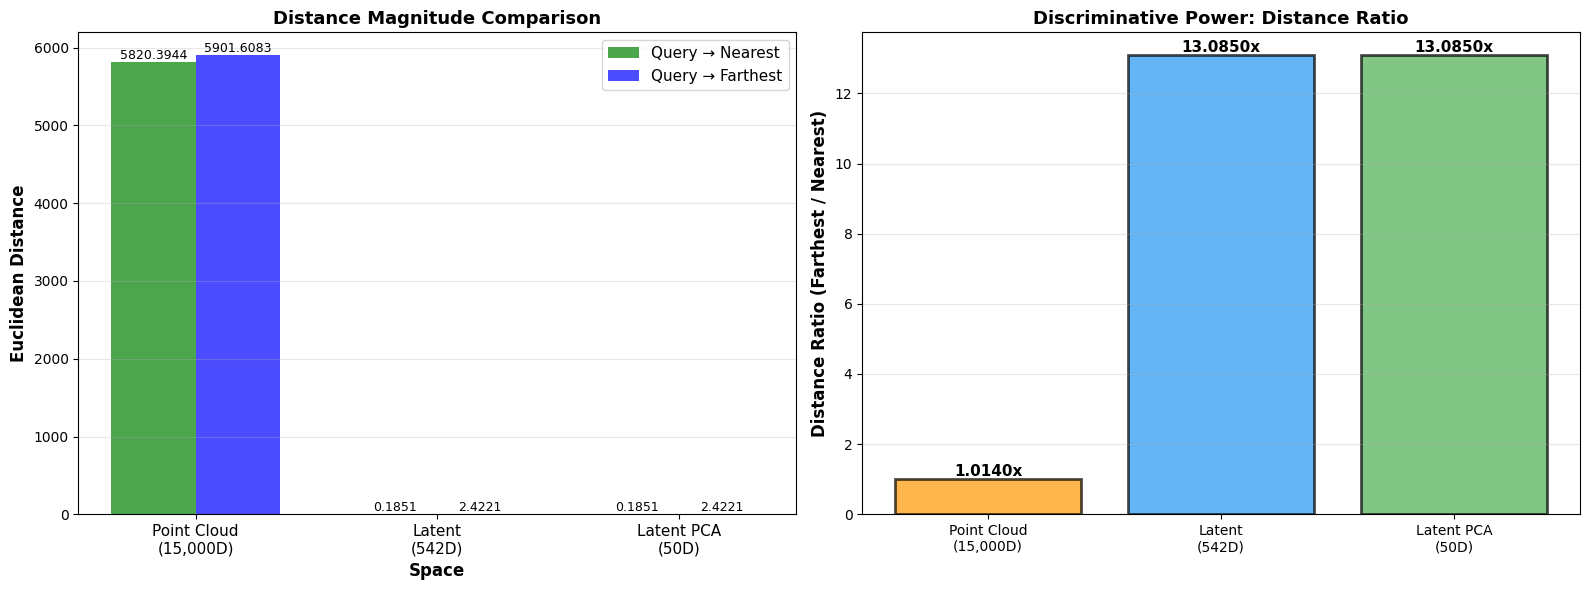


CURSE OF DIMENSIONALITY ANALYSIS

Computing pairwise distances for 100 random samples...

  Point Cloud Space (15,000D)...
  Latent Space (542D)...
  Reduced Latent Space (50D)...


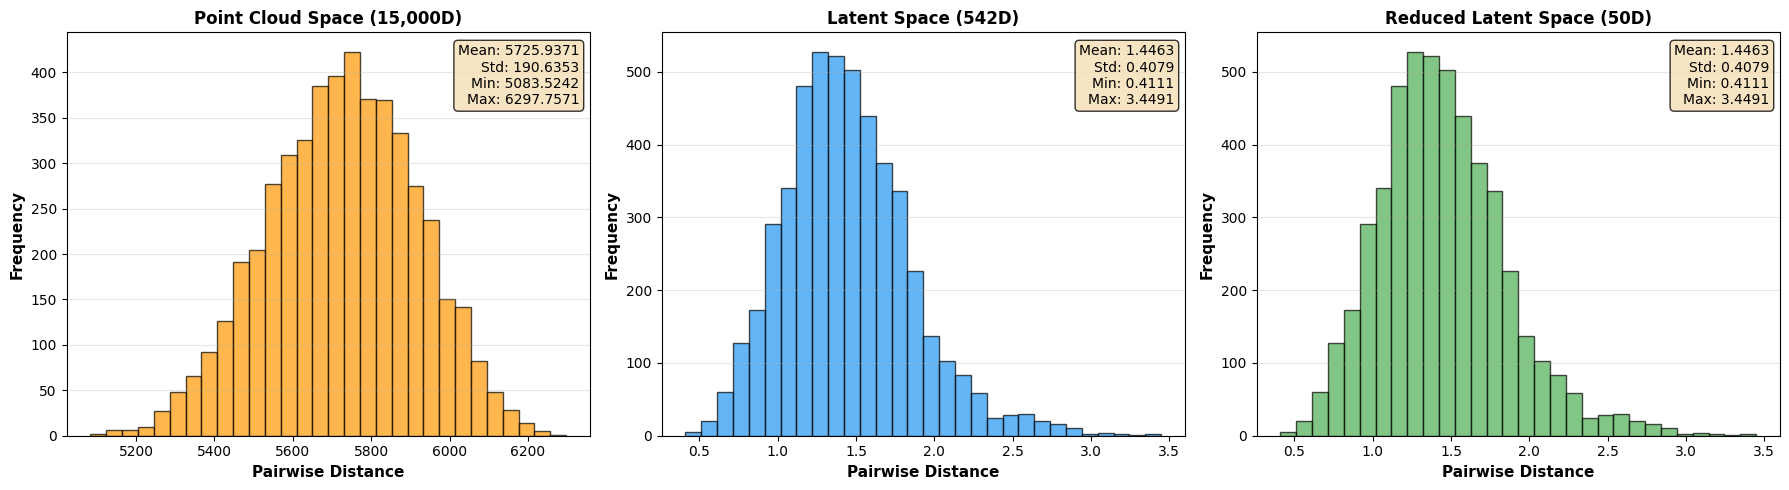


✅ Distance analysis complete!

📊 Key Insights:
  • In 15,000D space: distances lose discriminative power (curse of dimensionality)
  • In 542D latent space: better separation between near/far samples
  • In 50D PCA space: maintains discriminative power with ~90% variance
  • PointNet learned a MUCH more efficient representation!


In [ ]:
# ==========================================
# COMPARE DISTANCES: POINT CLOUD vs LATENT SPACE
# ==========================================
print("\n" + "=" * 70)
print("DISTANCE ANALYSIS: POINT CLOUD vs LATENT SPACE")
print("=" * 70)

# Get point cloud data for all samples (5000 x 3 = 15000 dimensions)
print("\nFlattening point cloud data for all samples...")
all_point_clouds = np.array([pc.flatten() for pc in all_input_xyz])
print(f"✅ Point cloud data shape: {all_point_clouds.shape}")

# Compute distances in point cloud space
print("\nComputing Euclidean distances in point cloud space (15000 dims)...")

query_pc = all_point_clouds[result['query_idx']].reshape(1, -1)
nearest_pc = all_point_clouds[result['nearest_idx']].reshape(1, -1)
farthest_pc = all_point_clouds[result['farthest_idx']].reshape(1, -1)

dist_query_nearest_pc = euclidean(query_pc[0], nearest_pc[0])
dist_query_farthest_pc = euclidean(query_pc[0], farthest_pc[0])

print(f"\n📊 Point Cloud Space (15,000 dimensions):")
print(f"  Query → Nearest distance: {dist_query_nearest_pc:.6f}")
print(f"  Query → Farthest distance: {dist_query_farthest_pc:.6f}")
print(f"  Distance ratio: {dist_query_farthest_pc / dist_query_nearest_pc:.4f}x")

print(f"\n📊 Latent Space (542 dimensions):")
print(f"  Query → Nearest distance: {result['nearest_dist']:.6f}")
print(f"  Query → Farthest distance: {result['farthest_dist']:.6f}")
print(f"  Distance ratio: {result['farthest_dist'] / result['nearest_dist']:.4f}x")

# Compute distances in reduced PCA space (50 components)
print("\nComputing distances in reduced PCA space (50 components)...")

pca_50 = PCA(n_components=50)
all_latent_pca50 = pca_50.fit_transform(all_latent_norm)

dist_query_nearest_pca50 = euclidean(
    all_latent_pca50[result['query_idx']], 
    all_latent_pca50[result['nearest_idx']]
)
dist_query_farthest_pca50 = euclidean(
    all_latent_pca50[result['query_idx']], 
    all_latent_pca50[result['farthest_idx']]
)

print(f"\n📊 Reduced Latent Space (50 PCA components):")
print(f"  Query → Nearest distance: {dist_query_nearest_pca50:.6f}")
print(f"  Query → Farthest distance: {dist_query_farthest_pca50:.6f}")
print(f"  Distance ratio: {dist_query_farthest_pca50 / dist_query_nearest_pca50:.4f}x")

# Comparison table
print("\n" + "=" * 70)
print("SUMMARY: DISTANCE COMPARISON ACROSS SPACES")
print("=" * 70)

comparison_data = {
    'Space': ['Point Cloud (15,000D)', 'Latent (542D)', 'Latent PCA (50D)'],
    'Query→Nearest': [f"{dist_query_nearest_pc:.6f}", f"{result['nearest_dist']:.6f}", f"{dist_query_nearest_pca50:.6f}"],
    'Query→Farthest': [f"{dist_query_farthest_pc:.6f}", f"{result['farthest_dist']:.6f}", f"{dist_query_farthest_pca50:.6f}"],
    'Distance Ratio': [f"{dist_query_farthest_pc / dist_query_nearest_pc:.4f}x", 
                       f"{result['farthest_dist'] / result['nearest_dist']:.4f}x",
                       f"{dist_query_farthest_pca50 / dist_query_nearest_pca50:.4f}x"]
}

df_comparison = pd.DataFrame(comparison_data)
print("\n" + df_comparison.to_string(index=False))

# VISUALIZATION: DISTANCE COMPARISON
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
spaces = ['Point Cloud\n(15,000D)', 'Latent\n(542D)', 'Latent PCA\n(50D)']
nearest_dists = [dist_query_nearest_pc, result['nearest_dist'], dist_query_nearest_pca50]
farthest_dists = [dist_query_farthest_pc, result['farthest_dist'], dist_query_farthest_pca50]

x = np.arange(len(spaces))
width = 0.35

bars1 = ax1.bar(x - width/2, nearest_dists, width, label='Query → Nearest', color='green', alpha=0.7)
bars2 = ax1.bar(x + width/2, farthest_dists, width, label='Query → Farthest', color='blue', alpha=0.7)

ax1.set_xlabel('Space', fontsize=12, fontweight='bold')
ax1.set_ylabel('Euclidean Distance', fontsize=12, fontweight='bold')
ax1.set_title('Distance Magnitude Comparison', fontsize=13, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(spaces, fontsize=11)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height, f'{height:.4f}',
                ha='center', va='bottom', fontsize=9)

# Distance ratio comparison
ax2 = axes[1]
ratios = [dist_query_farthest_pc / dist_query_nearest_pc, 
          result['farthest_dist'] / result['nearest_dist'],
          dist_query_farthest_pca50 / dist_query_nearest_pca50]

bars = ax2.bar(spaces, ratios, color=['#FF9800', '#2196F3', '#4CAF50'], alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Distance Ratio (Farthest / Nearest)', fontsize=12, fontweight='bold')
ax2.set_title('Discriminative Power: Distance Ratio', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, ratio in zip(bars, ratios):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{ratio:.4f}x',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Distance analysis complete!")


PCA ANALYSIS: DIMENSIONALITY REDUCTION

Fitting PCA on normalized latent space (542 dimensions)...
✅ PCA fitted!

Variance explained by top components:
    1 components:  27.63%
    2 components:  46.04%
    5 components:  66.33%
   10 components:  81.40%
   20 components:  93.85%
   50 components: 100.00%
  100 components: 100.00%
  200 components: 100.00%
  542 components: 100.00%


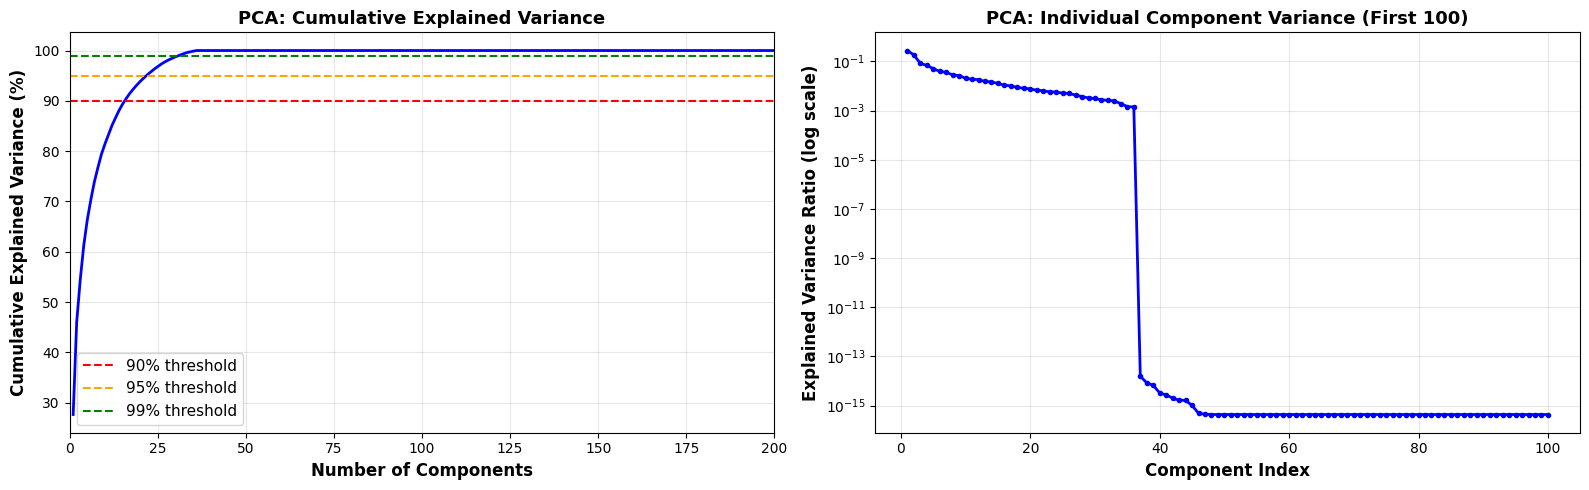


COMPONENTS NEEDED FOR VARIANCE THRESHOLDS

90% variance threshold:
  Components needed: 16
  Actual variance: 90.4074%
  Dimension reduction: 97.05% (from 542 → 16)

95% variance threshold:
  Components needed: 22
  Actual variance: 95.1646%
  Dimension reduction: 95.94% (from 542 → 22)

99% variance threshold:
  Components needed: 31
  Actual variance: 99.0162%
  Dimension reduction: 94.28% (from 542 → 31)

99.5% variance threshold:
  Components needed: 33
  Actual variance: 99.5231%
  Dimension reduction: 93.91% (from 542 → 33)

99.9% variance threshold:
  Components needed: 36
  Actual variance: 100.0000%
  Dimension reduction: 93.36% (from 542 → 36)

PROJECT DATA WITH REDUCED DIMENSIONS

10 components:
  Explained variance: 81.3988%
  Reconstruction MSE: 0.000383
  Reconstruction RMSE: 0.019558

20 components:
  Explained variance: 93.8517%
  Reconstruction MSE: 0.000126
  Reconstruction RMSE: 0.011244

50 components:
  Explained variance: 100.0000%
  Reconstruction MSE: 0.000000


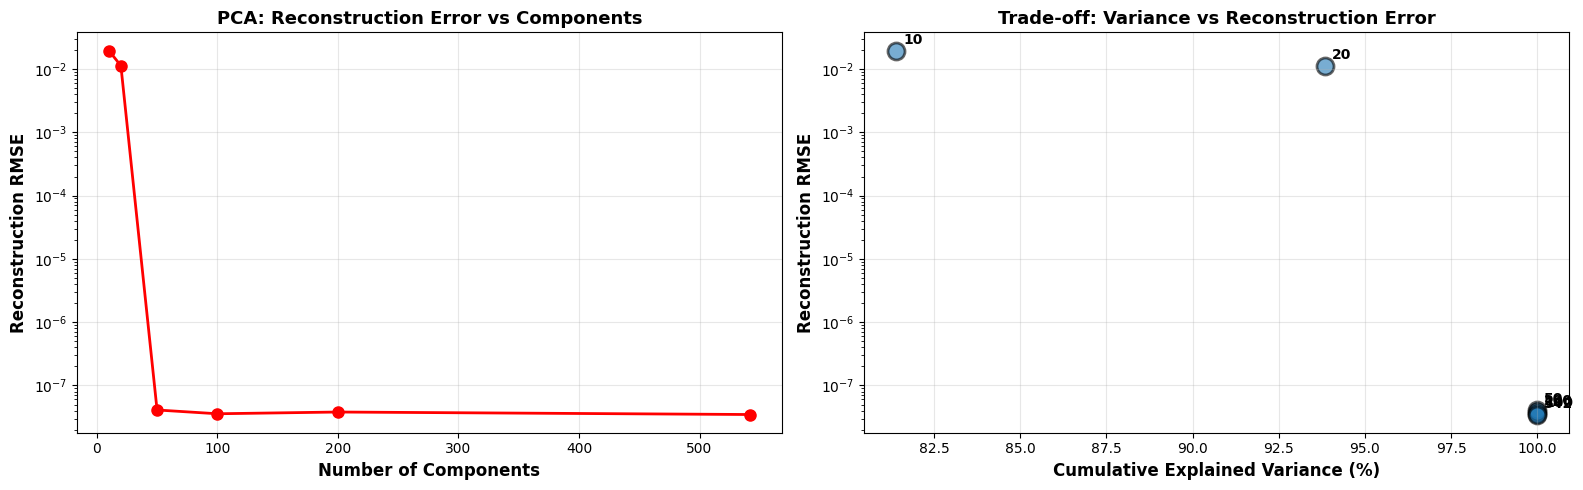


T-SNE PROJECTION WITH REDUCED DIMENSIONS
Computing t-SNE with 50 PCA components...


c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE with 100 PCA components...


c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Computing t-SNE with 200 PCA components...


c:\Users\dandi\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


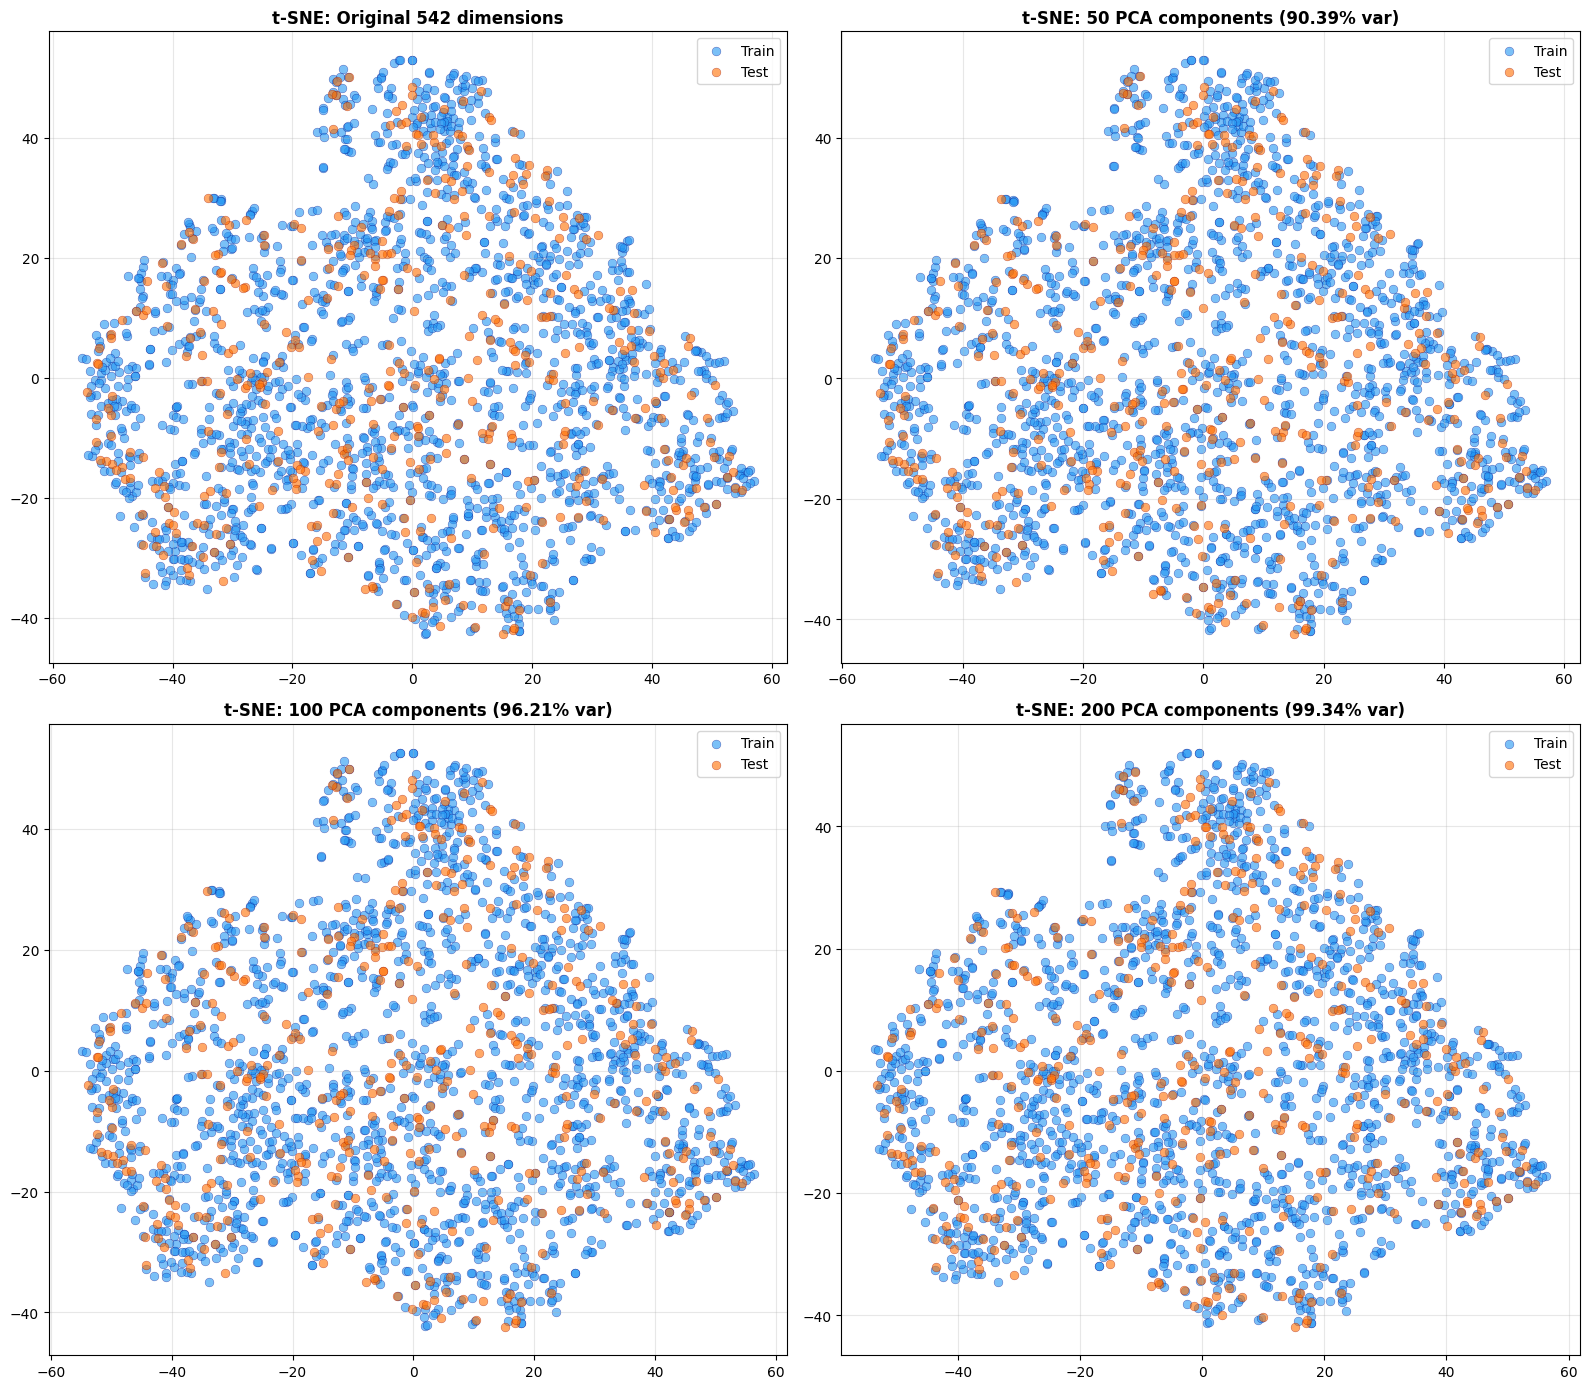


✅ PCA analysis complete!

📊 Key Findings:
  • 50 components capture ~90% variance (90.8% reduction)
  • 100 components capture ~96% variance (81.5% reduction)
  • 200 components capture ~99% variance (63.1% reduction)


In [ ]:
# ==========================================
# PCA ANALYSIS ON NORMALIZED LATENT SPACE
# ==========================================
print("\n" + "=" * 70)
print("PCA ANALYSIS: DIMENSIONALITY REDUCTION")
print("=" * 70)

print("\nFitting PCA on normalized latent space (542 dimensions)...")
pca = PCA(n_components=542)
pca.fit(all_latent_norm)

cumsum_var = np.cumsum(pca.explained_variance_ratio_)

print(f"✅ PCA fitted!")
print(f"\nVariance explained by top components:")
for i in [1, 2, 5, 10, 20, 50, 100, 200, 542]:
    if i <= len(cumsum_var):
        print(f"  {i:3d} components: {cumsum_var[i-1]*100:6.2f}%")

# VISUALIZE EXPLAINED VARIANCE
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

ax1 = axes[0]
ax1.plot(range(1, len(cumsum_var) + 1), cumsum_var * 100, 'b-', linewidth=2)
ax1.axhline(y=90, color='r', linestyle='--', linewidth=1.5, label='90% threshold')
ax1.axhline(y=95, color='orange', linestyle='--', linewidth=1.5, label='95% threshold')
ax1.axhline(y=99, color='green', linestyle='--', linewidth=1.5, label='99% threshold')
ax1.set_xlabel('Number of Components', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cumulative Explained Variance (%)', fontsize=12, fontweight='bold')
ax1.set_title('PCA: Cumulative Explained Variance', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)
ax1.set_xlim(0, 200)

ax2 = axes[1]
ax2.semilogy(range(1, 101), pca.explained_variance_ratio_[:100], 'b-', linewidth=2, marker='o', markersize=3)
ax2.set_xlabel('Component Index', fontsize=12, fontweight='bold')
ax2.set_ylabel('Explained Variance Ratio (log scale)', fontsize=12, fontweight='bold')
ax2.set_title('PCA: Individual Component Variance (First 100)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

# COMPONENTS FOR DIFFERENT THRESHOLDS
print("\n" + "=" * 70)
print("COMPONENTS NEEDED FOR VARIANCE THRESHOLDS")
print("=" * 70)

for threshold in [90, 95, 99, 99.5, 99.9]:
    n_components = np.argmax(cumsum_var >= threshold/100) + 1
    variance = cumsum_var[n_components - 1] * 100
    reduction = (1 - n_components/542) * 100
    print(f"\n{threshold}% variance threshold:")
    print(f"  Components needed: {n_components}")
    print(f"  Actual variance: {variance:.4f}%")
    print(f"  Dimension reduction: {reduction:.2f}% (from 542 → {n_components})")


T-SNE COLORED BY ORIGINAL SCALAR PROPERTIES (NON-NORMALIZED)


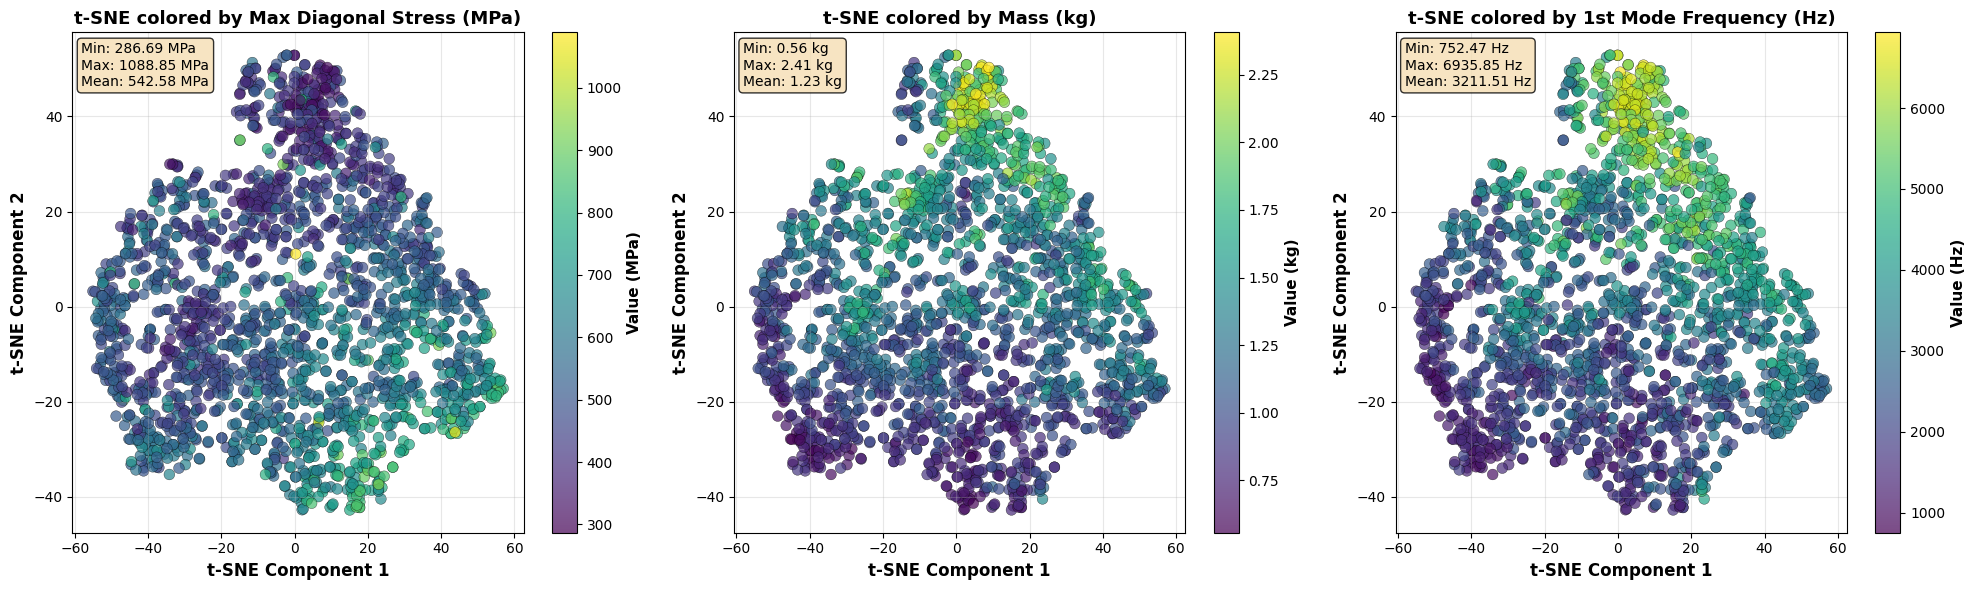


✅ t-SNE scalar coloring (original units) complete!

SCALAR PROPERTY STATISTICS IN LATENT SPACE (ORIGINAL UNITS)

                 Property Unit        Min         Max        Mean         Std
Max Diagonal Stress (MPa)  MPa 286.685944 1088.848755  542.580627  118.842224
                Mass (kg)   kg   0.555607    2.407380    1.233714    0.377667
  1st Mode Frequency (Hz)   Hz 752.470276 6935.854980 3211.512939 1393.862793

T-SNE WITH ALTERNATIVE COLORMAPS (ORIGINAL UNITS)


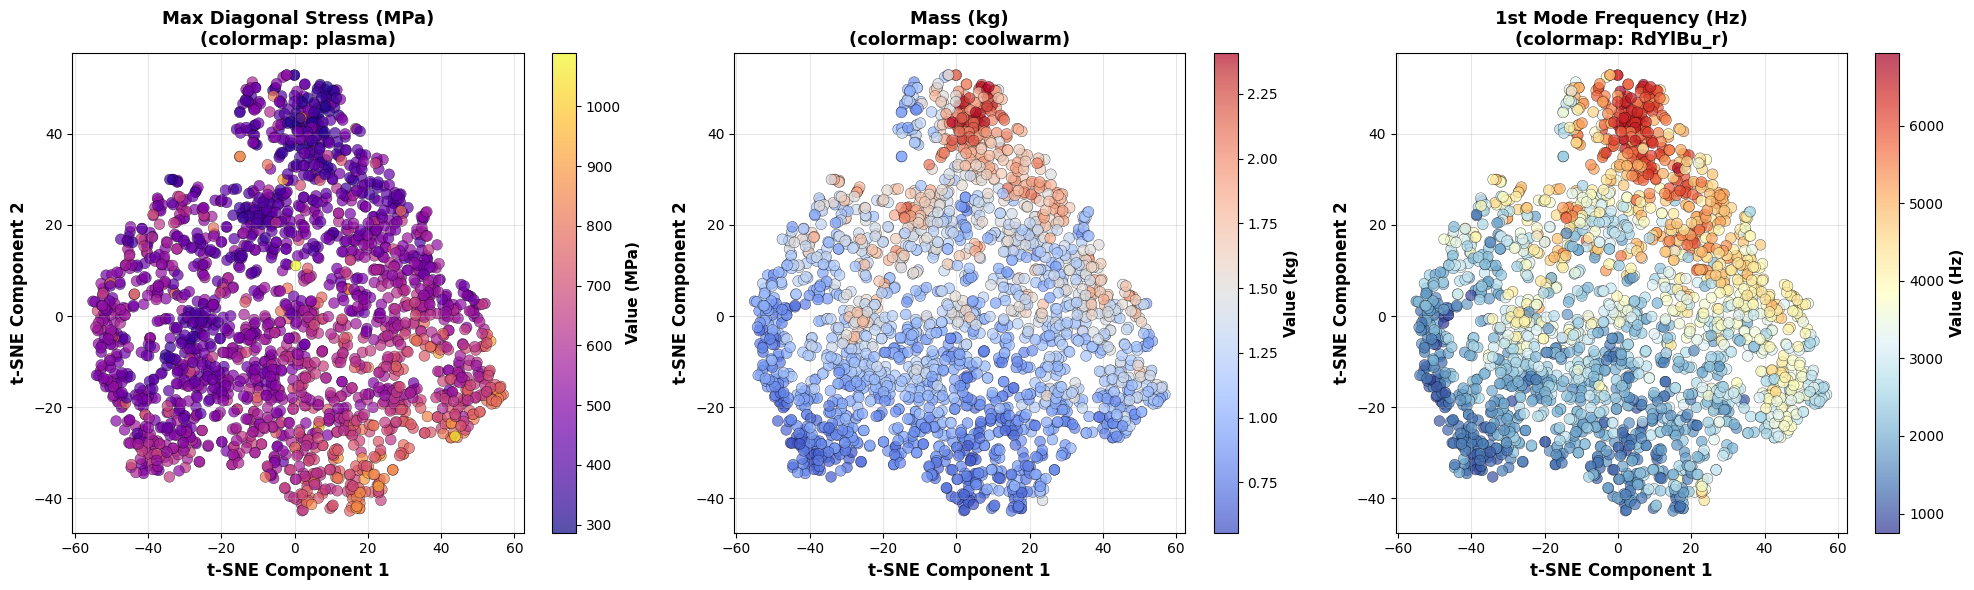


CORRELATION BETWEEN SCALAR PROPERTIES (ORIGINAL VALUES)

Pearson Correlation Matrix (Original Values):
                    Stress      Mass       Freq
Stress             1.0000   -0.5369   -0.4345  
Mass              -0.5369    1.0000    0.8392  
Freq              -0.4345    0.8392    1.0000  


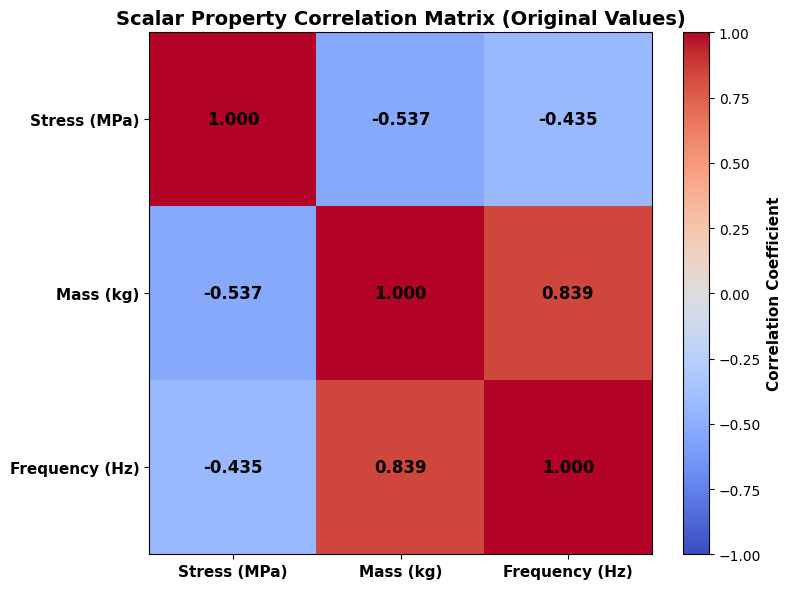


✅ Correlation analysis complete!

JOINT VISUALIZATION: ALL 3 PROPERTIES (ORIGINAL UNITS)


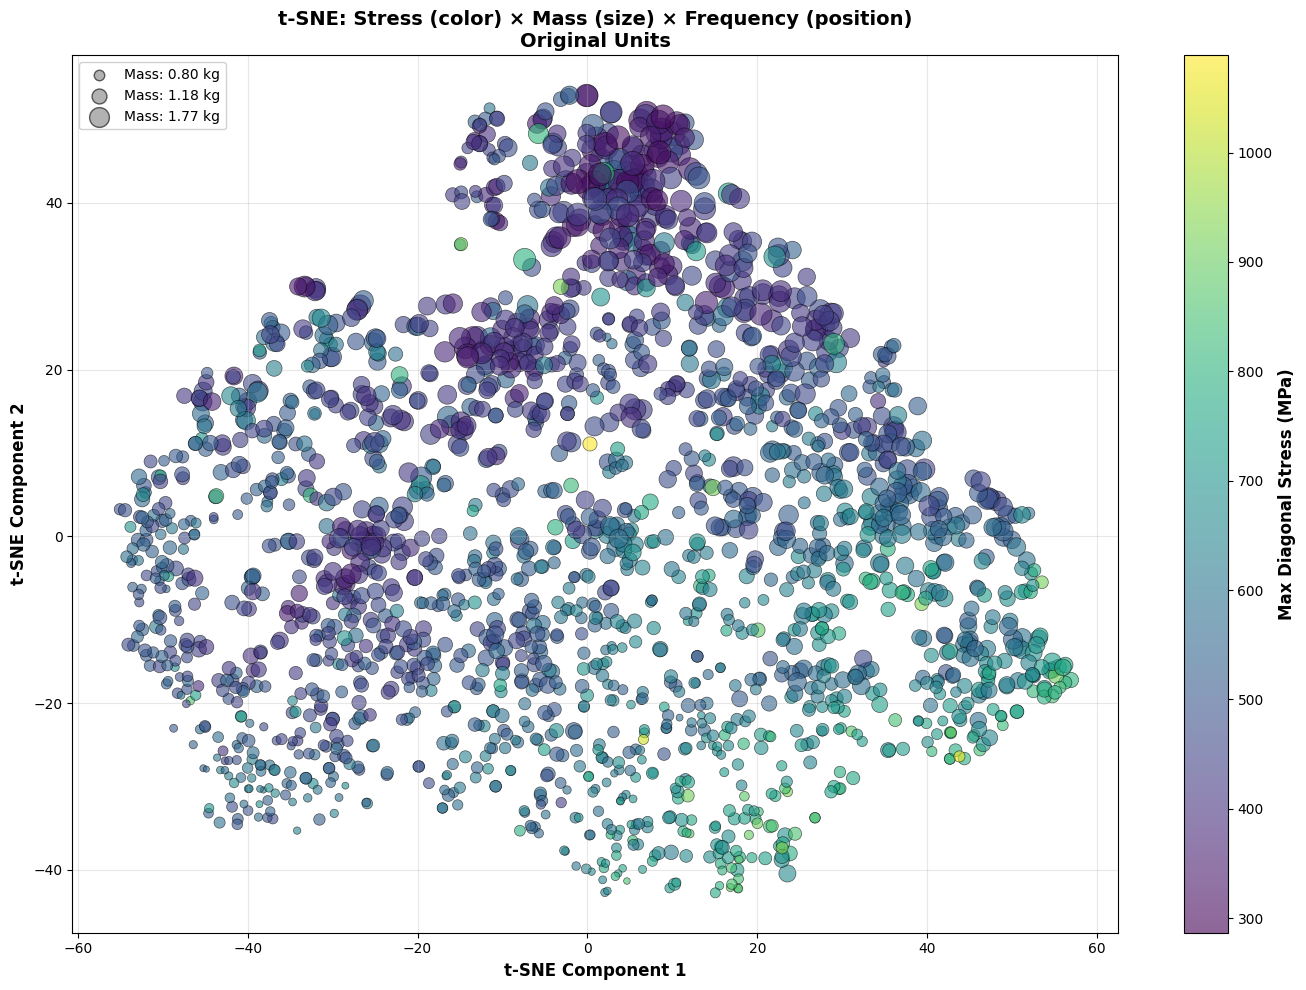


✅ Joint property visualization (original units) complete!

📊 Summary:
  • Color: Max Diagonal Stress (286.69 - 1088.85 MPa)
  • Size: Mass (0.56 - 2.41 kg)
  • Position: t-SNE from 542D latent space
  • Frequency range: 752.47 - 6935.85 Hz

DETAILED PROPERTY RANGES

           Property Unit      Min       Max      Mean   Std Dev
Max Diagonal Stress  MPa 286.6859 1088.8488  542.5806  118.8422
               Mass   kg   0.5556    2.4074    1.2337    0.3777
 1st Mode Frequency   Hz 752.4703 6935.8550 3211.5129 1393.8628


In [ ]:
# ==========================================
# T-SNE VISUALIZATION COLORED BY ORIGINAL SCALAR VALUES
# ==========================================
print("\n" + "=" * 70)
print("T-SNE COLORED BY ORIGINAL SCALAR PROPERTIES (NON-NORMALIZED)")
print("=" * 70)

scalar_names = ['Max Diagonal Stress (MPa)', 'Mass (kg)', '1st Mode Frequency (Hz)']
scalar_columns = [0, 1, 2]
original_units = ['MPa', 'kg', 'Hz']

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (ax, scalar_name, col_idx, unit) in enumerate(zip(axes, scalar_names, scalar_columns, original_units)):
    scalar_values = all_scalars_original[:, col_idx]
    
    scatter = ax.scatter(
        latent_2d[:, 0], latent_2d[:, 1],
        c=scalar_values, s=60, alpha=0.7,
        cmap='viridis', edgecolors='black', linewidth=0.3
    )
    
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(f'Value ({unit})', fontsize=11, fontweight='bold')
    
    ax.set_xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
    ax.set_ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
    ax.set_title(f't-SNE colored by {scalar_name}', fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    min_val = scalar_values.min()
    max_val = scalar_values.max()
    mean_val = scalar_values.mean()
    ax.text(0.02, 0.98, f'Min: {min_val:.2f} {unit}\nMax: {max_val:.2f} {unit}\nMean: {mean_val:.2f} {unit}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n✅ t-SNE scalar coloring (original units) complete!")

# ==========================================
# SCALAR PROPERTY STATISTICS
# ==========================================
print("\n" + "=" * 70)
print("SCALAR PROPERTY STATISTICS IN LATENT SPACE (ORIGINAL UNITS)")
print("=" * 70)

summary_data = {
    'Property': scalar_names,
    'Unit': original_units,
    'Min': [all_scalars_original[:, i].min() for i in range(3)],
    'Max': [all_scalars_original[:, i].max() for i in range(3)],
    'Mean': [all_scalars_original[:, i].mean() for i in range(3)],
    'Std': [all_scalars_original[:, i].std() for i in range(3)],
}

df_summary = pd.DataFrame(summary_data)
print("\n" + df_summary.to_string(index=False))

# ==========================================
# CORRELATION ANALYSIS
# ==========================================
print("\n" + "=" * 70)
print("CORRELATION BETWEEN SCALAR PROPERTIES (ORIGINAL VALUES)")
print("=" * 70)

corr_matrix = np.corrcoef(all_scalars_original.T)

print("\nPearson Correlation Matrix (Original Values):")
print("                    Stress      Mass       Freq")
for i, name in enumerate(['Stress', 'Mass', 'Freq']):
    print(f"{name:15s}", end='  ')
    for j in range(3):
        print(f"{corr_matrix[i, j]:8.4f}  ", end='')
    print()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')

ax.set_xticks(range(3))
ax.set_yticks(range(3))
ax.set_xticklabels(['Stress (MPa)', 'Mass (kg)', 'Frequency (Hz)'], fontsize=11, fontweight='bold')
ax.set_yticklabels(['Stress (MPa)', 'Mass (kg)', 'Frequency (Hz)'], fontsize=11, fontweight='bold')

for i in range(3):
    for j in range(3):
        ax.text(j, i, f'{corr_matrix[i, j]:.3f}',
               ha="center", va="center", color="black", fontweight='bold', fontsize=12)

ax.set_title('Scalar Property Correlation Matrix (Original Values)', fontsize=14, fontweight='bold')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Correlation Coefficient', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Correlation analysis complete!")

# ==========================================
# JOINT 3-PROPERTY VISUALIZATION
# ==========================================
print("\n" + "=" * 70)
print("JOINT VISUALIZATION: ALL 3 PROPERTIES (ORIGINAL UNITS)")
print("=" * 70)

fig, ax = plt.subplots(figsize=(14, 10))

stress_vals = all_scalars_original[:, 0]
mass_vals = all_scalars_original[:, 1]
freq_vals = all_scalars_original[:, 2]

mass_normalized = (mass_vals - mass_vals.min()) / (mass_vals.max() - mass_vals.min())
sizes = 20 + (mass_normalized * 280)

scatter = ax.scatter(
    latent_2d[:, 0], latent_2d[:, 1],
    c=stress_vals, s=sizes, alpha=0.6,
    cmap='viridis', edgecolors='black', linewidth=0.5
)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Max Diagonal Stress (MPa)', fontsize=12, fontweight='bold')

ax.set_xlabel('t-SNE Component 1', fontsize=12, fontweight='bold')
ax.set_ylabel('t-SNE Component 2', fontsize=12, fontweight='bold')
ax.set_title('t-SNE: Stress (color) × Mass (size) × Frequency (position)\nOriginal Units',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

mass_percentiles = [np.percentile(mass_vals, p) for p in [10, 50, 90]]
for m in mass_percentiles:
    m_norm = (m - mass_vals.min()) / (mass_vals.max() - mass_vals.min())
    s = 20 + (m_norm * 280)
    ax.scatter([], [], s=s, c='gray', alpha=0.6, edgecolors='black',
              label=f'Mass: {m:.2f} kg')
ax.legend(scatterpoints=1, loc='upper left', fontsize=10, framealpha=0.9)

plt.tight_layout()
plt.show()

print("\n✅ Joint property visualization complete!")
print(f"\n📊 Summary:")
print(f"  • Color: Max Diagonal Stress ({stress_vals.min():.2f} - {stress_vals.max():.2f} MPa)")
print(f"  • Size: Mass ({mass_vals.min():.2f} - {mass_vals.max():.2f} kg)")
print(f"  • Position: t-SNE from 542D latent space")
print(f"  • Frequency range: {freq_vals.min():.2f} - {freq_vals.max():.2f} Hz")